# MIMIC ML/DL

We compare ML and DL models for the NLP task of medical natural language inference (NLI), using a public database (MedNLI) derived from MIMIC-III clinical notes. 

We evaluate if ML and DL models can accurately infer whether a statement (hypothesis) contradicts or is consistent with text in a given context (premise). 

Poor performance at this task corresponds with the risk that an ML/AI agent responds unfortunately with a conclusion or diagnosis that conflicts with the text of the underlying clinical notes!



In [5]:
import warnings
warnings.filterwarnings("ignore")
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve
from tqdm import tqdm
import scispacy    # install in no higher than python 3.10
import spacy

# New Medical EHR Dataset: MedNLI

Romanov and Shivade (2018) introduced the expert-annotated “MedNLI” dataset for evaluating NLI in the clinical domain. 

- Uses the clinical notes in MIMIC-III v1.3 as the source of premises. 

- The hypothesis sentences were generated by clinicians. who were asked to write three sentences (hypotheses): 
    1. A clearly true statement,
    2. A clearly false statement, and 
    3. A statement that might be true or false.

References:
- https://github.com/jgc128/mednli
- Romanov, Alexey and Shivade, Chaitanya, Lessons from Natural Language Inference in the Clinical Domain, 2018.


In [6]:
# Helpers to read and process data
def read_jsonl(filename, max_samples=None):
    """helper to read jsonl files as pandas dataframe"""
    lines = []
    with open(filename) as f:
        lines = f.read().splitlines()
    line_dicts = [json.loads(line) for line in lines]
    max_samples = max_samples or len(line_dicts)
    return pd.DataFrame(line_dicts).iloc[:max_samples]

In [7]:
def process_data(df):
    """"helper to extract features and label from dataframe"""
    df = df[df['gold_label'].ne('neutral')]
    x = df[['sentence1', 'sentence2']]
    x.columns = ['premise', 'hypothesis']
    return x, df['gold_label'].eq('entailment').to_list()

In [8]:
# read in MedNLI train, dev and test sets
train_data, y_train = process_data(read_jsonl('mednli/mli_train_v1.jsonl'))
pd.Series(y_train).value_counts()

True     3744
False    3744
Name: count, dtype: int64

In [9]:
dev_data, y_dev = process_data(read_jsonl('mednli/mli_dev_v1.jsonl'))
pd.Series(y_dev).value_counts()


True     465
False    465
Name: count, dtype: int64

In [10]:
test_data, y_test = process_data(read_jsonl('mednli/mli_test_v1.jsonl'))
pd.Series(y_dev).value_counts()

True     465
False    465
Name: count, dtype: int64

In [11]:
# Show premise, hypothesis and label for dev examples
dev_data.assign(label=y_dev)

,premise,hypothesis,label
0,"No history of blood clots or DVTs, has never h...",Patient has angina,True
1,"No history of blood clots or DVTs, has never h...",Patient has had multiple PEs,False
3,Over the past week PTA he has been more somnol...,He has been less alert over the past week,True
4,Over the past week PTA he has been more somnol...,Over the past week he has been alert and orie...,False
6,COPD/Asthma: Spirometry ([**4-/3393**]) FVC 2....,the patient has a history of obstructive lung...,True
...,...,...,...
1387,History was taken entirely from the patients h...,the patient provided the history,False
1389,CAD s/p coronary bypass surgery [**3-16**]- LI...,The patient has a history of heart disease,True
1390,CAD s/p coronary bypass surgery [**3-16**]- LI...,The patient has no heart disease,False
1392,Her respiratory status seems to improve with n...,The patient is short of breath.,True


# Different Machine Learning Methods

We evaluated different ML methods, specifically: SVC, Quadratic Discriminant Analysis, Multi-layer Perceptrons, and Gaussian Naive Bayes.

__GaussianNB__

- Naive Bayes methods are based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. The conditional distribution of the features is assumed to be Gaussian.

__SVD__

- A support vector machine classifies data by finding an hyperplane that maximizes the distance between each class in an N-dimensional space. 
  - "C" is the regularization parameter which controls the trade-off between maximizing the margin and minimizing training errors. A small C focuses on maximizing the margin, potentially allowing some misclassifications (soft margin) and preventing overfitting.

__QuadraticDiscriminantAnalysis__

- QDA is derived from simple probabilistic models which model the class conditional distribution of the data for each class as a multivariate Gaussian distribution with unequal means and covariances. Predictions can then be obtained by using Bayes’ rule. 
If in the QDA model one assumes that the covariance matrices are diagonal, then the inputs are assumed to be conditionally independent in each class, and the resulting classifier is equivalent to the Gaussian Naive Bayes classifier

__MLPClassifier__

- Given a set of features and a target, Multi-layer Perceptron (MLP) learns a non-linear function approximator. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. Each layer transforms the values from the previous with a weighted linear summation followed by a non-linear activation function.  The weights are learned by backpropagation over many iterations.

  - ”alpha” is the strength of the L2 regularization term.
  - “max_iter” specifies the maximum number of iterations. The solver iterates until convergence or this number of iterations



In [12]:
def get_model(model):
    """helper to return a ML model class and name"""
    match model :
        case 0 :
            return "GaussianNB", GaussianNB()
        case 1 :
            return "SVC", SVC(kernel="linear", C=0.025, random_state=42)
        case 2 :
            return "QDA", QuadraticDiscriminantAnalysis()
        case _ :
            return "NeuralNet", MLPClassifier(alpha=1, max_iter=1000, random_state=42)

## Word Embeddings as Features

We use a bag-of-words (BOW) approach, as implement in spaCy, to construct features to represent the premise and hypothesis passages. An input passage is represented as a single vector by taking the average of the vectors of individual tokens. The premise and hypothesis vectors are then concatenated and passed through to the ML classifier.

Another potential improvement is to consider domain-specific word embeddings. We use word vectors from ScispaCy, which was specialized for processing biomedical texts by retraining spaCy models using datasets relevant to biomedical text.

References:

- https://spacy.io/models/en
- https://github.com/allenai/scispacy



In [13]:
#SpaCy models
#!python -m spacy download en_core_web_sm
#!python -m spacy download en_core_web_md
#!python -m spacy download en_core_web_lg
#nlp = spacy.load("en_core_web_sm")  # k=96
#nlp = spacy.load("en_core_web_md")  # 20K vocab, k=300
#nlp = spacy.load("en_core_web_lg")  # 514K vocab, k=300
#
#- SciSpaCy: urls of latest models at https://github.com/allenai/scispacy 
#pip install <model URL>
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz
#nlp = spacy.load("en_core_sci_sm")  # 100K vocab, k=96
#nlp = spacy.load("en_core_sci_md")  # 360K vocab, k=200
#nlp = spacy.load("en_core_sci_lg")  # 785K vocab, k=200


In [14]:
# List of embeddings models to compare
embed_names = ["en_core_sci_sm", "en_core_sci_md", "en_core_sci_lg",
               "en_core_web_sm", "en_core_web_md", "en_core_web_lg"]

## Evaluate ML and embeddings models

Evaluate test prediction accuracy of all 4 ML models, comparing each of the 6 different word embeddings models for generating features.

Embedding 7488 train examples with en_core_sci_sm...


7488it [01:14, 100.87it/s]


Embedding 948 dev examples with en_core_sci_sm...


930it [00:09, 97.44it/s] 


Embedding 948 test examples with en_core_sci_sm...


948it [00:09, 103.10it/s]




GaussianNB model with en_core_sci_sm embeddings
-----------------------------------------------
Test Set Accuracy: 0.658  (Test Set: 0.683

Classification Report:
              precision    recall  f1-score   support

           0      0.643     0.713     0.676       474
           1      0.678     0.603     0.638       474

    accuracy                          0.658       948
   macro avg      0.660     0.658     0.657       948
weighted avg      0.660     0.658     0.657       948


Confusion Matrix:
       Predicted     
               0    1
True 0       338  136
     1       188  286
AUC: 0.727


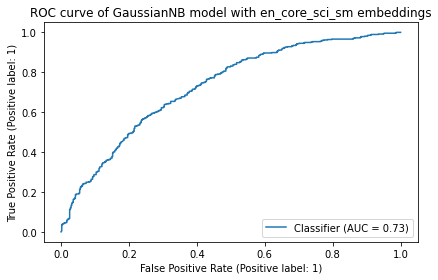



SVC model with en_core_sci_sm embeddings
----------------------------------------
Test Set Accuracy: 0.730  (Test Set: 0.758

Classification Report:
              precision    recall  f1-score   support

           0      0.760     0.673     0.714       474
           1      0.706     0.787     0.745       474

    accuracy                          0.730       948
   macro avg      0.733     0.730     0.729       948
weighted avg      0.733     0.730     0.729       948


Confusion Matrix:
       Predicted     
               0    1
True 0       319  155
     1       101  373


QDA model with en_core_sci_sm embeddings
----------------------------------------
Test Set Accuracy: 0.772  (Test Set: 0.875

Classification Report:
              precision    recall  f1-score   support

           0      0.787     0.747     0.766       474
           1      0.759     0.797     0.778       474

    accuracy                          0.772       948
   macro avg      0.773     0.772     0.772   

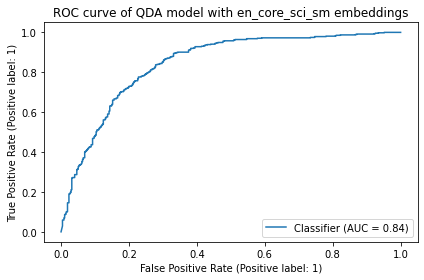



NeuralNet model with en_core_sci_sm embeddings
----------------------------------------------
Test Set Accuracy: 0.772  (Test Set: 0.858

Classification Report:
              precision    recall  f1-score   support

           0      0.761     0.793     0.777       474
           1      0.784     0.751     0.767       474

    accuracy                          0.772       948
   macro avg      0.773     0.772     0.772       948
weighted avg      0.773     0.772     0.772       948


Confusion Matrix:
       Predicted     
               0    1
True 0       376   98
     1       118  356
AUC: 0.864


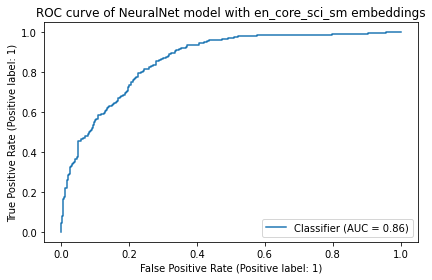

Embedding 7488 train examples with en_core_sci_md...


7488it [01:19, 93.86it/s] 


Embedding 948 dev examples with en_core_sci_md...


930it [00:10, 88.45it/s]


Embedding 948 test examples with en_core_sci_md...


948it [00:09, 96.37it/s] 




GaussianNB model with en_core_sci_md embeddings
-----------------------------------------------
Test Set Accuracy: 0.682  (Test Set: 0.695

Classification Report:
              precision    recall  f1-score   support

           0      0.668     0.726     0.696       474
           1      0.700     0.639     0.668       474

    accuracy                          0.682       948
   macro avg      0.684     0.682     0.682       948
weighted avg      0.684     0.682     0.682       948


Confusion Matrix:
       Predicted     
               0    1
True 0       344  130
     1       171  303
AUC: 0.759


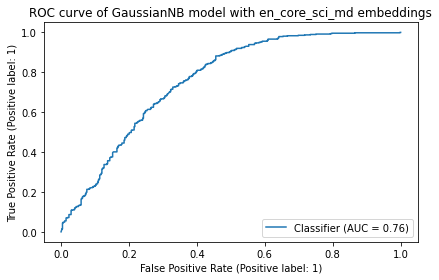



SVC model with en_core_sci_md embeddings
----------------------------------------
Test Set Accuracy: 0.746  (Test Set: 0.761

Classification Report:
              precision    recall  f1-score   support

           0      0.801     0.654     0.720       474
           1      0.708     0.838     0.767       474

    accuracy                          0.746       948
   macro avg      0.754     0.746     0.744       948
weighted avg      0.754     0.746     0.744       948


Confusion Matrix:
       Predicted     
               0    1
True 0       310  164
     1        77  397


QDA model with en_core_sci_md embeddings
----------------------------------------
Test Set Accuracy: 0.747  (Test Set: 0.890

Classification Report:
              precision    recall  f1-score   support

           0      0.744     0.753     0.748       474
           1      0.750     0.741     0.745       474

    accuracy                          0.747       948
   macro avg      0.747     0.747     0.747   

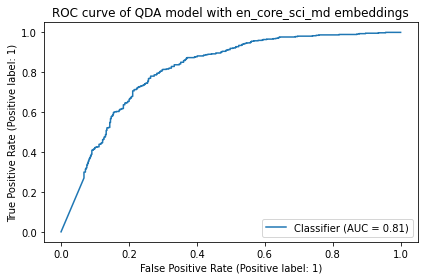



NeuralNet model with en_core_sci_md embeddings
----------------------------------------------
Test Set Accuracy: 0.777  (Test Set: 0.794

Classification Report:
              precision    recall  f1-score   support

           0      0.773     0.785     0.779       474
           1      0.782     0.770     0.776       474

    accuracy                          0.777       948
   macro avg      0.777     0.777     0.777       948
weighted avg      0.777     0.777     0.777       948


Confusion Matrix:
       Predicted     
               0    1
True 0       372  102
     1       109  365
AUC: 0.865


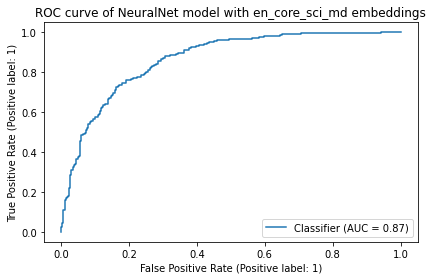

Embedding 7488 train examples with en_core_sci_lg...


7488it [01:20, 93.22it/s] 


Embedding 948 dev examples with en_core_sci_lg...


930it [00:09, 93.30it/s] 


Embedding 948 test examples with en_core_sci_lg...


948it [00:10, 91.54it/s] 




GaussianNB model with en_core_sci_lg embeddings
-----------------------------------------------
Test Set Accuracy: 0.679  (Test Set: 0.694

Classification Report:
              precision    recall  f1-score   support

           0      0.667     0.717     0.691       474
           1      0.694     0.641     0.667       474

    accuracy                          0.679       948
   macro avg      0.680     0.679     0.679       948
weighted avg      0.680     0.679     0.679       948


Confusion Matrix:
       Predicted     
               0    1
True 0       340  134
     1       170  304
AUC: 0.759


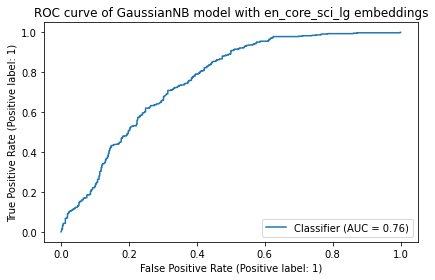



SVC model with en_core_sci_lg embeddings
----------------------------------------
Test Set Accuracy: 0.735  (Test Set: 0.757

Classification Report:
              precision    recall  f1-score   support

           0      0.796     0.633     0.705       474
           1      0.695     0.838     0.760       474

    accuracy                          0.735       948
   macro avg      0.746     0.735     0.732       948
weighted avg      0.746     0.735     0.732       948


Confusion Matrix:
       Predicted     
               0    1
True 0       300  174
     1        77  397


QDA model with en_core_sci_lg embeddings
----------------------------------------
Test Set Accuracy: 0.745  (Test Set: 0.893

Classification Report:
              precision    recall  f1-score   support

           0      0.739     0.757     0.748       474
           1      0.751     0.732     0.741       474

    accuracy                          0.745       948
   macro avg      0.745     0.745     0.745   

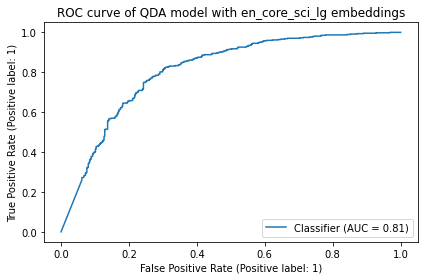



NeuralNet model with en_core_sci_lg embeddings
----------------------------------------------
Test Set Accuracy: 0.771  (Test Set: 0.796

Classification Report:
              precision    recall  f1-score   support

           0      0.762     0.789     0.775       474
           1      0.781     0.753     0.767       474

    accuracy                          0.771       948
   macro avg      0.771     0.771     0.771       948
weighted avg      0.771     0.771     0.771       948


Confusion Matrix:
       Predicted     
               0    1
True 0       374  100
     1       117  357
AUC: 0.862


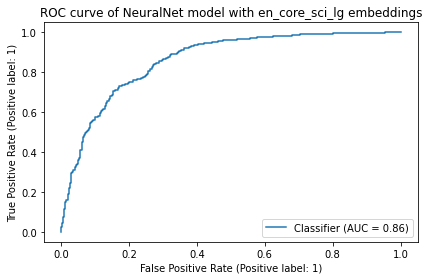

Embedding 7488 train examples with en_core_web_sm...


7488it [01:03, 117.71it/s]


Embedding 948 dev examples with en_core_web_sm...


930it [00:07, 116.87it/s]


Embedding 948 test examples with en_core_web_sm...


948it [00:07, 118.87it/s]




GaussianNB model with en_core_web_sm embeddings
-----------------------------------------------
Test Set Accuracy: 0.635  (Test Set: 0.664

Classification Report:
              precision    recall  f1-score   support

           0      0.625     0.677     0.650       474
           1      0.647     0.593     0.619       474

    accuracy                          0.635       948
   macro avg      0.636     0.635     0.634       948
weighted avg      0.636     0.635     0.634       948


Confusion Matrix:
       Predicted     
               0    1
True 0       321  153
     1       193  281
AUC: 0.700


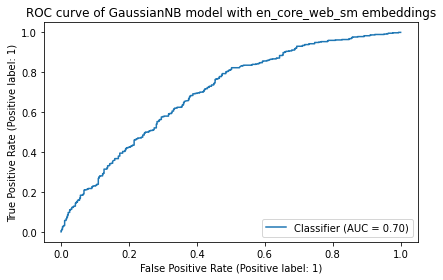



SVC model with en_core_web_sm embeddings
----------------------------------------
Test Set Accuracy: 0.735  (Test Set: 0.752

Classification Report:
              precision    recall  f1-score   support

           0      0.759     0.690     0.723       474
           1      0.716     0.781     0.747       474

    accuracy                          0.735       948
   macro avg      0.737     0.735     0.735       948
weighted avg      0.737     0.735     0.735       948


Confusion Matrix:
       Predicted     
               0    1
True 0       327  147
     1       104  370


QDA model with en_core_web_sm embeddings
----------------------------------------
Test Set Accuracy: 0.753  (Test Set: 0.871

Classification Report:
              precision    recall  f1-score   support

           0      0.760     0.741     0.750       474
           1      0.747     0.766     0.756       474

    accuracy                          0.753       948
   macro avg      0.753     0.753     0.753   

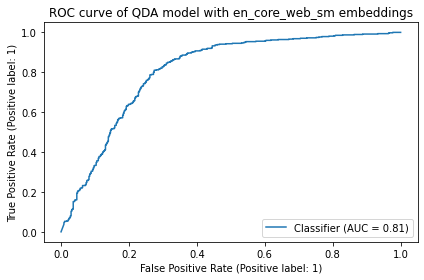



NeuralNet model with en_core_web_sm embeddings
----------------------------------------------
Test Set Accuracy: 0.773  (Test Set: 0.815

Classification Report:
              precision    recall  f1-score   support

           0      0.811     0.713     0.759       474
           1      0.744     0.833     0.786       474

    accuracy                          0.773       948
   macro avg      0.777     0.773     0.772       948
weighted avg      0.777     0.773     0.772       948


Confusion Matrix:
       Predicted     
               0    1
True 0       338  136
     1        79  395
AUC: 0.852


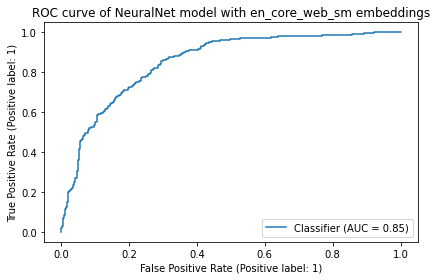

Embedding 7488 train examples with en_core_web_md...


7488it [01:09, 107.18it/s]


Embedding 948 dev examples with en_core_web_md...


930it [00:08, 106.79it/s]


Embedding 948 test examples with en_core_web_md...


948it [00:08, 110.78it/s]




GaussianNB model with en_core_web_md embeddings
-----------------------------------------------
Test Set Accuracy: 0.705  (Test Set: 0.711

Classification Report:
              precision    recall  f1-score   support

           0      0.758     0.601     0.671       474
           1      0.670     0.808     0.732       474

    accuracy                          0.705       948
   macro avg      0.714     0.705     0.701       948
weighted avg      0.714     0.705     0.701       948


Confusion Matrix:
       Predicted     
               0    1
True 0       285  189
     1        91  383
AUC: 0.770


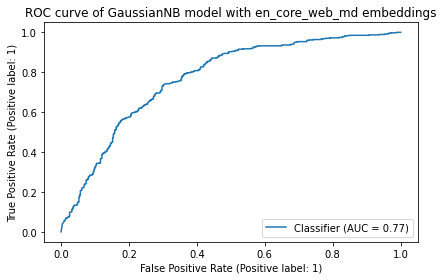



SVC model with en_core_web_md embeddings
----------------------------------------
Test Set Accuracy: 0.766  (Test Set: 0.808

Classification Report:
              precision    recall  f1-score   support

           0      0.806     0.700     0.749       474
           1      0.735     0.831     0.780       474

    accuracy                          0.766       948
   macro avg      0.770     0.766     0.765       948
weighted avg      0.770     0.766     0.765       948


Confusion Matrix:
       Predicted     
               0    1
True 0       332  142
     1        80  394


QDA model with en_core_web_md embeddings
----------------------------------------
Test Set Accuracy: 0.731  (Test Set: 0.894

Classification Report:
              precision    recall  f1-score   support

           0      0.723     0.749     0.736       474
           1      0.740     0.713     0.726       474

    accuracy                          0.731       948
   macro avg      0.731     0.731     0.731   

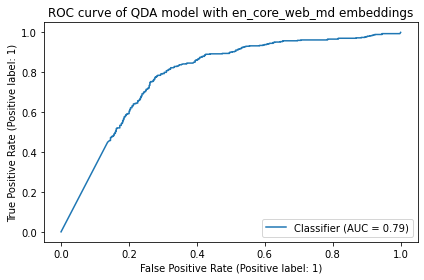



NeuralNet model with en_core_web_md embeddings
----------------------------------------------
Test Set Accuracy: 0.803  (Test Set: 0.953

Classification Report:
              precision    recall  f1-score   support

           0      0.846     0.741     0.790       474
           1      0.769     0.865     0.814       474

    accuracy                          0.803       948
   macro avg      0.808     0.803     0.802       948
weighted avg      0.808     0.803     0.802       948


Confusion Matrix:
       Predicted     
               0    1
True 0       351  123
     1        64  410
AUC: 0.886


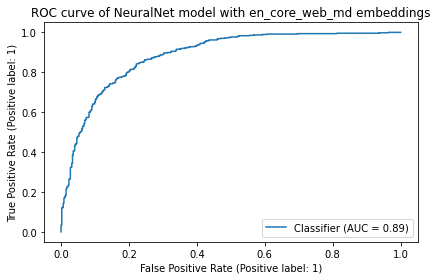

Embedding 7488 train examples with en_core_web_lg...


7488it [01:08, 109.05it/s]


Embedding 948 dev examples with en_core_web_lg...


930it [00:08, 105.89it/s]


Embedding 948 test examples with en_core_web_lg...


948it [00:08, 110.62it/s]




GaussianNB model with en_core_web_lg embeddings
-----------------------------------------------
Test Set Accuracy: 0.710  (Test Set: 0.709

Classification Report:
              precision    recall  f1-score   support

           0      0.765     0.605     0.676       474
           1      0.674     0.814     0.737       474

    accuracy                          0.710       948
   macro avg      0.719     0.710     0.707       948
weighted avg      0.719     0.710     0.707       948


Confusion Matrix:
       Predicted     
               0    1
True 0       287  187
     1        88  386
AUC: 0.763


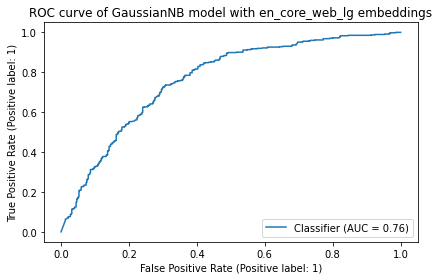



SVC model with en_core_web_lg embeddings
----------------------------------------
Test Set Accuracy: 0.783  (Test Set: 0.811

Classification Report:
              precision    recall  f1-score   support

           0      0.827     0.715     0.767       474
           1      0.749     0.850     0.796       474

    accuracy                          0.783       948
   macro avg      0.788     0.783     0.782       948
weighted avg      0.788     0.783     0.782       948


Confusion Matrix:
       Predicted     
               0    1
True 0       339  135
     1        71  403


QDA model with en_core_web_lg embeddings
----------------------------------------
Test Set Accuracy: 0.732  (Test Set: 0.890

Classification Report:
              precision    recall  f1-score   support

           0      0.717     0.768     0.741       474
           1      0.750     0.696     0.722       474

    accuracy                          0.732       948
   macro avg      0.733     0.732     0.732   

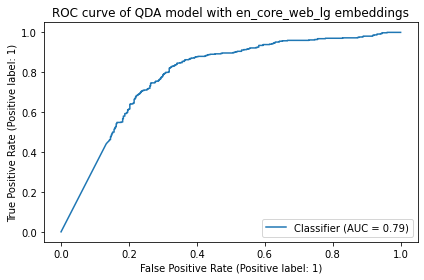



NeuralNet model with en_core_web_lg embeddings
----------------------------------------------
Test Set Accuracy: 0.806  (Test Set: 0.951

Classification Report:
              precision    recall  f1-score   support

           0      0.868     0.722     0.788       474
           1      0.762     0.890     0.821       474

    accuracy                          0.806       948
   macro avg      0.815     0.806     0.805       948
weighted avg      0.815     0.806     0.805       948


Confusion Matrix:
       Predicted     
               0    1
True 0       342  132
     1        52  422
AUC: 0.897


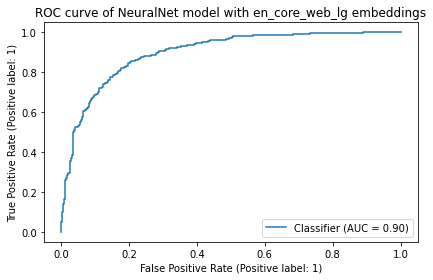

In [15]:
# Outer training loop over word embedding models
ml_results = {}
for embed_name in embed_names:
    ml_results[embed_name] = dict()

    # Convert text data to embeddings features
    nlp = spacy.load(embed_name)   # load embedding model
    print(f'Embedding {len(train_data)} train examples with {embed_name}...')
    X_train = [np.concatenate((nlp(premise).vector, nlp(hypothesis).vector))
               for row, premise, hypothesis in tqdm(train_data.itertuples())]
    print(f'Embedding {len(test_data)} dev examples with {embed_name}...')
    X_dev = [np.concatenate((nlp(premise).vector, nlp(hypothesis).vector))
             for row, premise, hypothesis in tqdm(dev_data.itertuples())]
    print(f'Embedding {len(test_data)} test examples with {embed_name}...')
    X_test = [np.concatenate((nlp(premise).vector, nlp(hypothesis).vector))
              for row, premise, hypothesis in tqdm(test_data.itertuples())]

    # Inner loop over ML models
    for model in range(4):
        clf_name, clf = get_model(model)

        # Fit the model
        clf.fit(X_train, y_train)
        train_acc = clf.score(X_train, y_train)

        # Get test set predictions
        X, y_true = X_test, [int(y==1) for y in y_test]
        y_pred = [int(y == 1) for y in clf.predict(X)]
        labels = np.unique(y_true)

        # Calculate accuracy
        title = f"{clf_name} model with {embed_name} embeddings"
        print(f"\n\n{'=' * len(title)}\n{title}\n{'-' * len(title)}")
        accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
        ml_results[embed_name][clf_name] = accuracy
        print(f'Test Set Accuracy: {accuracy:.3f}  (Test Set: {train_acc:.3f}')

        class_report = classification_report(y_true=y_true, y_pred=y_pred, digits=3)
        print('\nClassification Report:')
        print(class_report)

        # Generate confusion matrix, with labels
        conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
        print('\nConfusion Matrix:')
        print(pd.DataFrame(
            conf_matrix,
            index=pd.MultiIndex.from_product([['True'], labels]),
            columns=pd.MultiIndex.from_product([['Predicted'], labels])
        ))

        # Generate AUC/ROC plot
        if 'SVC' not in clf_name:
            y_proba = clf.predict_proba(X)[:, 1]
            print(f'AUC: {roc_auc_score(y_true, y_proba):.3f}')
            RocCurveDisplay.from_predictions(y_true, y_proba)
            plt.title(f"ROC curve of {clf_name} model with {embed_name} embeddings")
            plt.tight_layout()
            plt.show()

## Final Results of ML Methods


In [16]:
# Test accuracy results
print(pd.DataFrame(ml_results).T.round(3))

                GaussianNB    SVC    QDA  NeuralNet
en_core_sci_sm       0.658  0.730  0.772      0.772
en_core_sci_md       0.682  0.746  0.747      0.777
en_core_sci_lg       0.679  0.735  0.745      0.771
en_core_web_sm       0.635  0.735  0.753      0.773
en_core_web_md       0.705  0.766  0.731      0.803
en_core_web_lg       0.710  0.783  0.732      0.806


In [12]:
# Helper to plot results as grouped bar charts
def grouped_bar(data, title='', ylabel=''):
    """Helper to plot group bar charts 
       - grouped by row, 
       - each column is a bar in a group
    """
    xticks = data.index.to_list()    # x labels
    x = np.arange(len(xticks))       # the x label locations
    y = data.to_dict(orient='list')  # dict of column -> list of values
    
    fig, ax = plt.subplots(layout='constrained', figsize=(10, 7))
    width = 1/(len(y) + 1)  # the width of the bars

    # for each column of data, incrementally offset its plot location
    for column, (attribute, measurement) in enumerate(y.items()):
        offset = width * column 
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        column += 1

    # round up ylim by base decimal (e.g. 18 -> 20)
    _, ylim = ax.get_ylim()
    base =  10**(np.floor(np.log10(ylim)))
    YGAP = 0.05  # amount of upper gap for ylim, 0.0 if no gap
    ax.set_ylim(0, np.floor(1 + (ylim / base) + YGAP) * base)
    ax.legend(loc='upper left', ncols=len(y))
    ax.set_xticks(x + width, xticks)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

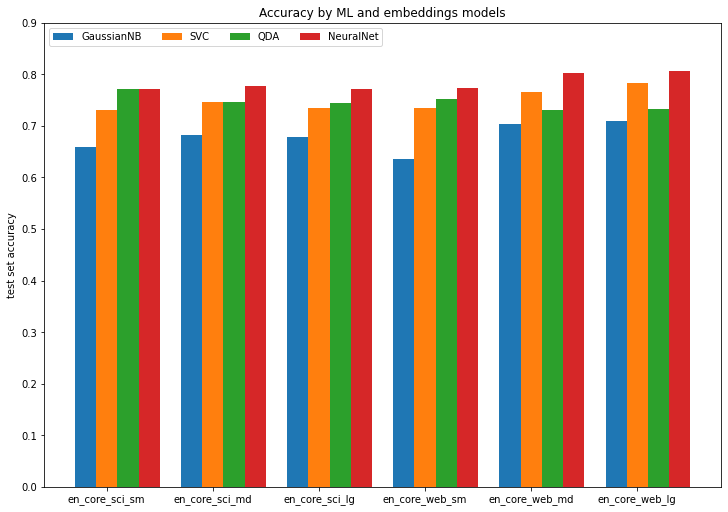

In [13]:
# Grouped bar plot table of test set accuracy evaluations
grouped_bar(pd.DataFrame(ml_results).T,
            title='Accuracy by ML and embeddings models',
            ylabel='test set accuracy')

# Different Deep Learning Designs

The previous ML methods, including the MLP neural network, used Bag-of-Words average vectors to represent both premise and hypothesis text passages. They completely ignored the order of words in the text, which may be critical for the NLP task.

A recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data. While traditional deep neural networks assume that inputs and outputs are independent of each other, the output of recurrent neural networks depend on the prior elements within the sequence.

We evaluated different DL designs, specifically different variations of Recurrent Neural Networks such as Simple Elman RNN, LSTM and GRU, which can capture the sequential interrelationships (that may be based on complex semantics and syntax rules), and not just the presence, of words in the text.


## Prepare data

The vectors data of a spaCy model can be converted to an EmbeddingLayer tensor, which serves as a “lookup” table in a Pytorch network model. 

To process the text inputs and convert words to row id’s, the following spaCy methods are called:
- vocab.strings() to convert a word string to a hash representation
- vectors.key2row() to retrieve the integer row id from a hash key


In [14]:
# Use "en_core_web_lg" embeddings model
nlp = spacy.load("en_core_web_lg")
txt = dev_data['premise'].iloc[0]
nlp(txt).vector.shape

(300,)

In [15]:
# Helper to construct sequence of token id's as a tensor
def prepare_sequence(premise, hypothesis, vocab):
    """Returns sequence of token id's for premise:hypothesis, given vocab model"""
    
    def get_token_id(word):
        """Get row id of word in embedding layer"""
        # print(word)
        return vocab.vectors.key2row[vocab.strings[word]]

    def tokenize(txt):
        """Convert strings to list of row id's, excluding special token ':'"""
        txt = txt.replace(".", " . ")\
                 .replace(",", " , ")\
                 .replace(";", " ; ")\
                 .replace("?", " ? ")\
                 .replace(":", " ")      # ignore special token
        tokens = [get_token_id(word)
                  for word in txt.lower().split()
                  if vocab.strings[word] in vocab.vectors]
        return tokens

    # Concatenate premise and hypothesis, separated by unique token ':'
    sequence = tokenize(premise) + [get_token_id(":")] + tokenize(hypothesis)
    return torch.tensor(sequence)

In [16]:
# Example of a sequence
premise = dev_data['premise'].iloc[0]
hypothesis = dev_data['hypothesis'].iloc[0]
sequence = prepare_sequence(premise, hypothesis, nlp.vocab)
sequence

tensor([   90,   497,     4,   972, 38213,    39,     2,    50,   213,    67,
         4567,  1381,  1771,     5,    54,   356,   594,     1,    38,  1820,
           50, 58039])

In [17]:
# Extract vectors as a (frozen) torch embedding layer
embed_weights = torch.FloatTensor(nlp.vocab.vectors.data)
embed_layer = torch.nn.Embedding.from_pretrained(embed_weights, freeze=True)

In [18]:
# Confirms that lookup of embedding layer is same as vocab vectors
word = "healthcare"
vector = nlp.vocab.vectors[nlp.vocab.strings[word]]
embedding = embed_layer(torch.LongTensor([
    nlp.vocab.vectors.key2row[nlp.vocab.strings[word]]]))
np.testing.assert_almost_equal(vector, embedding.squeeze().numpy())

## Design the DL models

- Simple Elman RNN: A RNN module updates a hidden state, in addition to emitting an output prediction, after each input token.  The hidden state of an RNN can capture historical information of the sequence up to the current time step. Hence with recurrent computation, the number of RNN model parameters does not grow as the number of time steps increases. After the model has taken a forward pass through all tokens in a sequence, the output of the last time step is passed as input to the final classifier layer.

- LSTM: There are variations of recurrent neural networks that are more powerful. One such variation is the Long Short-Term Memory (LSTM) module. An LSTM is is better at capturing long-term dependencies. Instead of having only one hidden state, an LSTM keeps track of both a hidden state and a cell state.

- GRU: Another variation of an RNN is the Gated-Recurrent Unit (GRU). The GRU was invented after LSTM, and is intended to be a simplification of the LSTM that is still just as powerful. GRU units have only one hidden state.

References:
- https://www.cs.toronto.edu/~lczhang/321/lec/rnn_notes.html

In [19]:
class MedRNN(torch.nn.Module):
    """Define the Elman RNN model"""
    def __init__(self, num_classes, hidden_size, embed_weights):
        super(MedRNN, self).__init__()
        self.emb = torch.nn.Embedding.from_pretrained(embed_weights)
        self.hidden_size = hidden_size
        input_size = embed_weights.shape[-1]    # dimension of embeddings
        # input format is [batch_size, seq_len, input_size]
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)              # Look up the embedding
        out, _ = self.rnn(x)         # Forward propagate the RNN
        out = self.fc(out[:, -1, :]) # Pass output of last time step to classifier
        return out

In [20]:
class MedLSTM(torch.nn.Module):
    """Define the LSTM model"""
    def __init__(self, num_classes, hidden_size, embed_weights):
        super(MedLSTM, self).__init__()
        self.emb = torch.nn.Embedding.from_pretrained(embed_weights)
        self.hidden_size = hidden_size
        input_size = embed_weights.shape[-1]    # dimension of embeddings
        # input format is [batch_size, seq_len, input_size]
        self.rnn = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)   # Look up the embedding
        h0 = torch.zeros(1, x.size(0), self.hidden_size)   # set initial hidden state
        c0 = torch.zeros(1, x.size(0), self.hidden_size)   # and cell state
        out, _ = self.rnn(x, (h0, c0))  # Forward propagate the LSTM
        out = self.fc(out[:, -1, :])    # Pass output of last time step to classifier
        return out

In [21]:
class MedGRU(torch.nn.Module):
    """Define the GRU model"""
    def __init__(self, num_classes, hidden_size, embed_weights):
        super(MedGRU, self).__init__()
        self.emb = torch.nn.Embedding.from_pretrained(embed_weights)
        self.hidden_size = hidden_size
        input_size = embed_weights.shape[-1]    # dimension of embeddings
        # input format is [batch_size, seq_len, input_size]
        self.rnn = torch.nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)               # Look up the embedding
        out, _ = self.rnn(x)          # Forward propagate the GRU 
        out = self.fc(out[:, -1, :])  # Pass output of last time step to classifier
        return out

In [22]:
models = {'MedRNN': MedRNN, 'MedLSTM': MedLSTM, 'MedGRU': MedGRU}

### Helpers for model evaluation


In [23]:
def get_accuracy(model, X, y):
    """computes accuracy of model predictions"""
    with torch.no_grad():
        correct = 0
        for row in range(len(X)):
            premise, hypothesis = X.iloc[row]
            train = prepare_sequence(premise, hypothesis, nlp.vocab)
            pred = model(train.unsqueeze(0)).detach().numpy()   # add batch dimension
            correct += (pred.argmax() == y[row])
    return correct / len(X)

## Train the Models

- Each model is trained for 64 epochs, with the training data randomly shuffled each epoch.

- The “Adam” optimizer is used with a fixed learning rate set to 1e-5.

- The CrossEntropyLoss criterion is simply the generalized version of logistic loss when there are multiple classes. 

- Batching was not employed (and input sequences need not be padded to equal lengths), so an additional dimension is inserted into each input tensor.


100%|██████████| 64/64 [18:27<00:00, 17.30s/it]


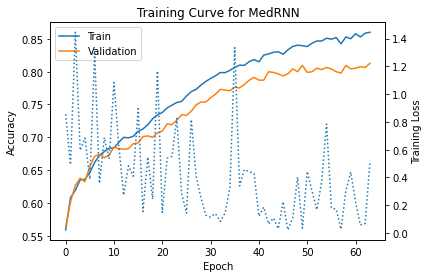

100%|██████████| 64/64 [39:35<00:00, 37.12s/it]


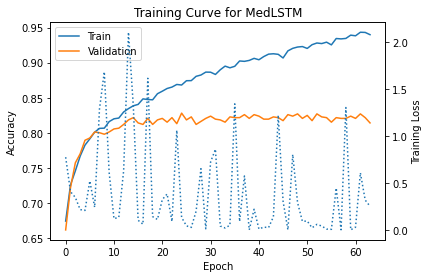

100%|██████████| 64/64 [38:43<00:00, 36.31s/it]


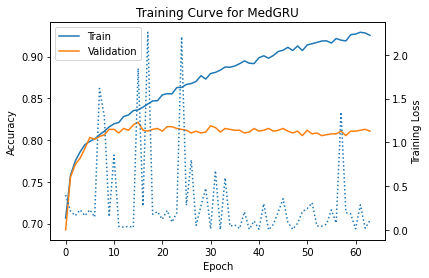

In [24]:
dl_results = dict()
for model_name, model_class in models.items():
    model = model_class(num_classes=2, hidden_size=50, embed_weights=embed_weights)

    # Optimization parameters
    num_epochs = 64
    learning_rate = 1e-5
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop over epochs
    losses, train_acc, valid_acc, test_acc, epochs = [], [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        rows = np.arange(len(train_data))
        np.random.shuffle(rows)   # randomize order of training examples
        for row in rows:
            premise, hypothesis = train_data.iloc[row]
            labels = torch.tensor(int(y_train[row])).unsqueeze(0)
            train = prepare_sequence(premise, hypothesis, nlp.vocab).unsqueeze(0)
            optimizer.zero_grad()
            model.train()
            pred = model(train)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            model.eval()

        # Record accuracy and loss after each epoch
        losses.append(float(loss))
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_data, y_train))
        valid_acc.append(get_accuracy(model, dev_data, y_dev))
        test_acc.append(get_accuracy(model, test_data, y_test))
        #print("%s: Epoch %d; Loss %f; Train Acc %f; Val Acc %f; Test Acc %f" % (
        #      model_name, epoch+1, loss, train_acc[-1], valid_acc[-1], test_acc[-1]))

    # store results
    best = np.argmax(valid_acc)  # select epoch with best *validation* set result
    dl_results[model_name] = {'epochs': epoch+1, 'best': best+1, 'train': train_acc[best],
                              'dev': valid_acc[best], 'test': test_acc[best]}

    # plot training curve
    fig, ax = plt.subplots(1, 1)
    ax.set_title(f"Training Curve for {model_name}")
    ax.plot(epochs, train_acc, label="Train")
    ax.plot(epochs, valid_acc, label="Validation")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend(loc='best')
    bx = ax.twinx()
    bx.plot(losses, label="Train", ls=':')
    bx.set_ylabel("Training Loss")
    plt.show()

## Final Results of the Deep Learning Designs

- Although the training set curves continue to improve (overfit), the validation curves flatten out after 15 epochs for MedLSTM and MedGRU, and after 50 epochs for MedRNN.
  
- For each DL model, we picked the epoch where “validation set” accuracy was greatest, and then reported their “test set” accuracy. In other words, we employed the cross-validation approach to determine the max_epochs hyperparameter.

- The GRU model slightly outperformed LSTM, and both performed better than the simple Elman RNN.

- GRU and LSTM also attained their peak cross-validation scores much earlier (epochs 16 and 25 respectively).

- The test accuracy of 0.7911 for GRU was slightly lower than that of the Multi-Layer Perceptron Neural Network method which achieved test accuracy 0.806.


In [25]:
pd.DataFrame(dl_results)['best':].round(4)

,MedRNN,MedLSTM,MedGRU
best,64.0000,25.0000,16.0000
train,0.8602,0.8681,0.8363
dev,0.8129,0.8280,0.8215
test,0.7827,0.7880,0.7911


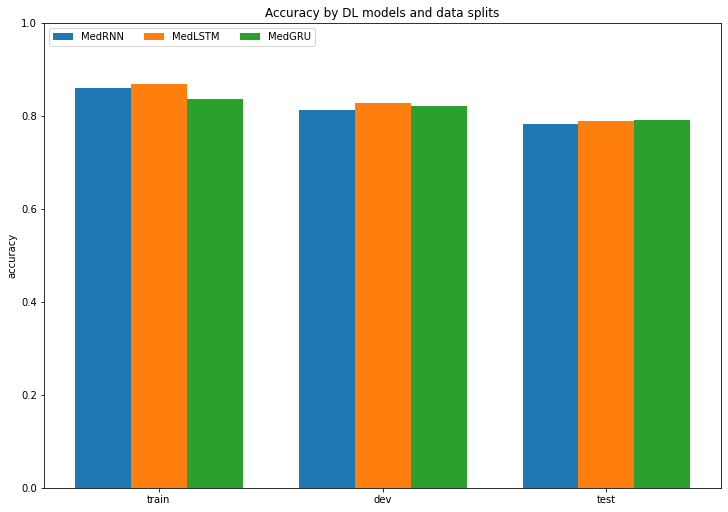

In [26]:
grouped_bar(pd.DataFrame(dl_results)['train':],
            title='Accuracy by DL models and data splits',
            ylabel='accuracy')